# Challenge 1: Exploratory Data Analysis for Producer's Direct, GHCND, and the World Bank Climate Portal

## Overview

This notebook contains a simple EDA for the parquet file of the Producer's Direct farmer's questions, and EDA for the 
Global Historical Climatology Network and World Bank Climate Portal, where station information, model estimation bias, and monthly/yearly trends were explored. 

## Inspecting Producers Direct Data Set

In [1]:
import os 
import duckdb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pyarrow as pa
import gcsfs

from pathlib import Path

In [2]:
# Path to Producer's Direct parquet file.
current_directory = Path(os.getcwd())
parquet_file_path =  current_directory.joinpath('../../data/b0cd514b-b9cc-4972-a0c2-c91726e6d825.parquet')

In [3]:
# Observing the schema of the data.
conn = duckdb.connect()

df_schema = conn.execute(f"DESCRIBE '{parquet_file_path}'").fetchdf()
print(df_schema)

                   column_name               column_type null   key default  \
0                  question_id                    BIGINT  YES  None    None   
1             question_user_id                    BIGINT  YES  None    None   
2            question_language                   VARCHAR  YES  None    None   
3             question_content                   VARCHAR  YES  None    None   
4               question_topic                   VARCHAR  YES  None    None   
5                question_sent  TIMESTAMP WITH TIME ZONE  YES  None    None   
6                  response_id                    BIGINT  YES  None    None   
7             response_user_id                    BIGINT  YES  None    None   
8            response_language                   VARCHAR  YES  None    None   
9             response_content                   VARCHAR  YES  None    None   
10              response_topic                   VARCHAR  YES  None    None   
11               response_sent  TIMESTAMP WITH TIME 

In [4]:
# Summary counts of the whole data frame and some specific attributes.
query_summary = f"""
    SELECT
        COUNT(*) AS total_records,
        COUNT(DISTINCT question_language) AS distinct_question_languages,
        COUNT(DISTINCT question_topic) AS distinct_question_topics,
        COUNT(DISTINCT response_topic) AS distinct_response_topics,
    FROM '{parquet_file_path}';
"""

query_summary_record = conn.execute(query_summary).fetchdf()
print("Summary Record:")
print(query_summary_record)

Summary Record:
   total_records  distinct_question_languages  distinct_question_topics  \
0       20304843                            4                       148   

   distinct_response_topics  
0                       150  


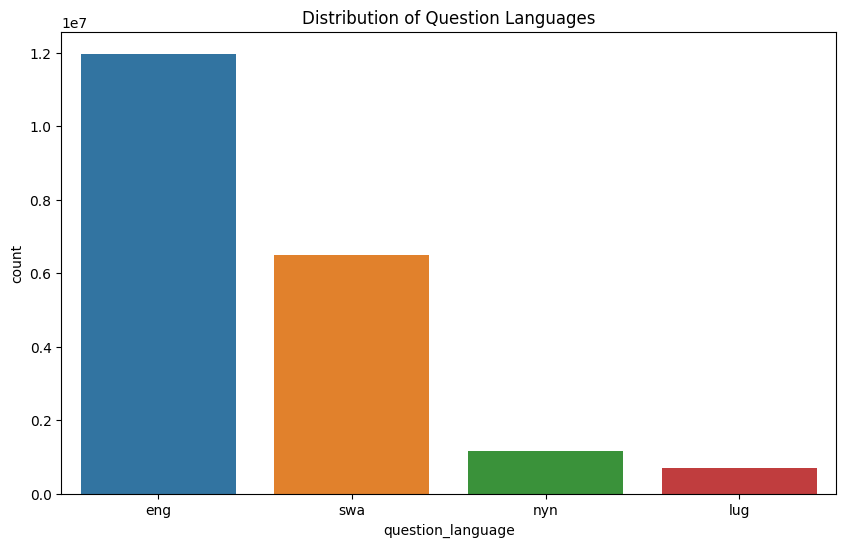

In [5]:
# Bar plot visualization of language distribution in the dataset.

conn.sql(f"""
    CREATE TEMP VIEW all_data AS
    SELECT *
    FROM '{parquet_file_path}'
""")

query_lang_distrib = f"""
    SELECT 
        question_language,
        COUNT(*) AS count,
    FROM all_data
    GROUP BY
        question_language,
    ORDER BY
        count DESC;
"""
lang_distrib = conn.execute(query_lang_distrib).fetchdf()

plt.figure(figsize=(10, 6))
sns.barplot(lang_distrib, x='question_language', y='count', hue='question_language')
plt.title('Distribution of Question Languages')
plt.show()

In [6]:
# Querying to get the top ten topics and converting them into a list

query_top_ten_topics = f"""
    SELECT
        question_topic,
        COUNT(*) AS count
    FROM all_data
    GROUP BY
        question_topic,
    ORDER BY
        count DESC
    LIMIT 10;
"""
top_ten_topics = conn.execute(query_top_ten_topics).fetchdf()

top_ten_topics_list = list(top_ten_topics.iloc[:, 0])
top_ten_topics

,question_topic,count
0,None,3537729
1,maize,2201755
2,cattle,1675473
3,chicken,1667251
4,tomato,1096386
5,poultry,1051797
6,plant,1024498
7,bean,732120
8,crop,602913
9,goat,434284


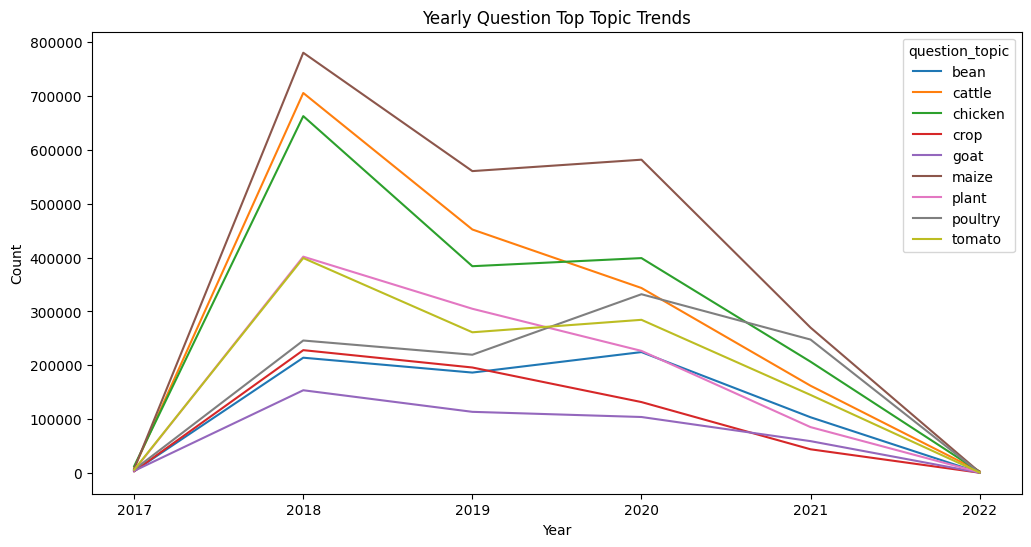

In [7]:
# Visualizing line plot of the yearly top topic trends, note: 'None' topic does not show up in these visualizations

query_yearly_top_topics = f"""
    SELECT
        strftime(question_sent, '%Y') AS year,
        question_topic,
        COUNT(*) AS count
    FROM all_data
    WHERE question_topic IN ({','.join([f"'{topic}'" for topic in top_ten_topics_list])})
    GROUP BY
        year,
        question_topic,
    ORDER BY
        year,
        question_topic;
"""

yearly_top_topics = conn.execute(query_yearly_top_topics).fetchdf()

plt.figure(figsize=(12, 6))
sns.lineplot(data=yearly_top_topics, x='year', y='count', hue='question_topic')
plt.xlabel('Year')
plt.ylabel('Count')
plt.title('Yearly Question Top Topic Trends')
plt.show()

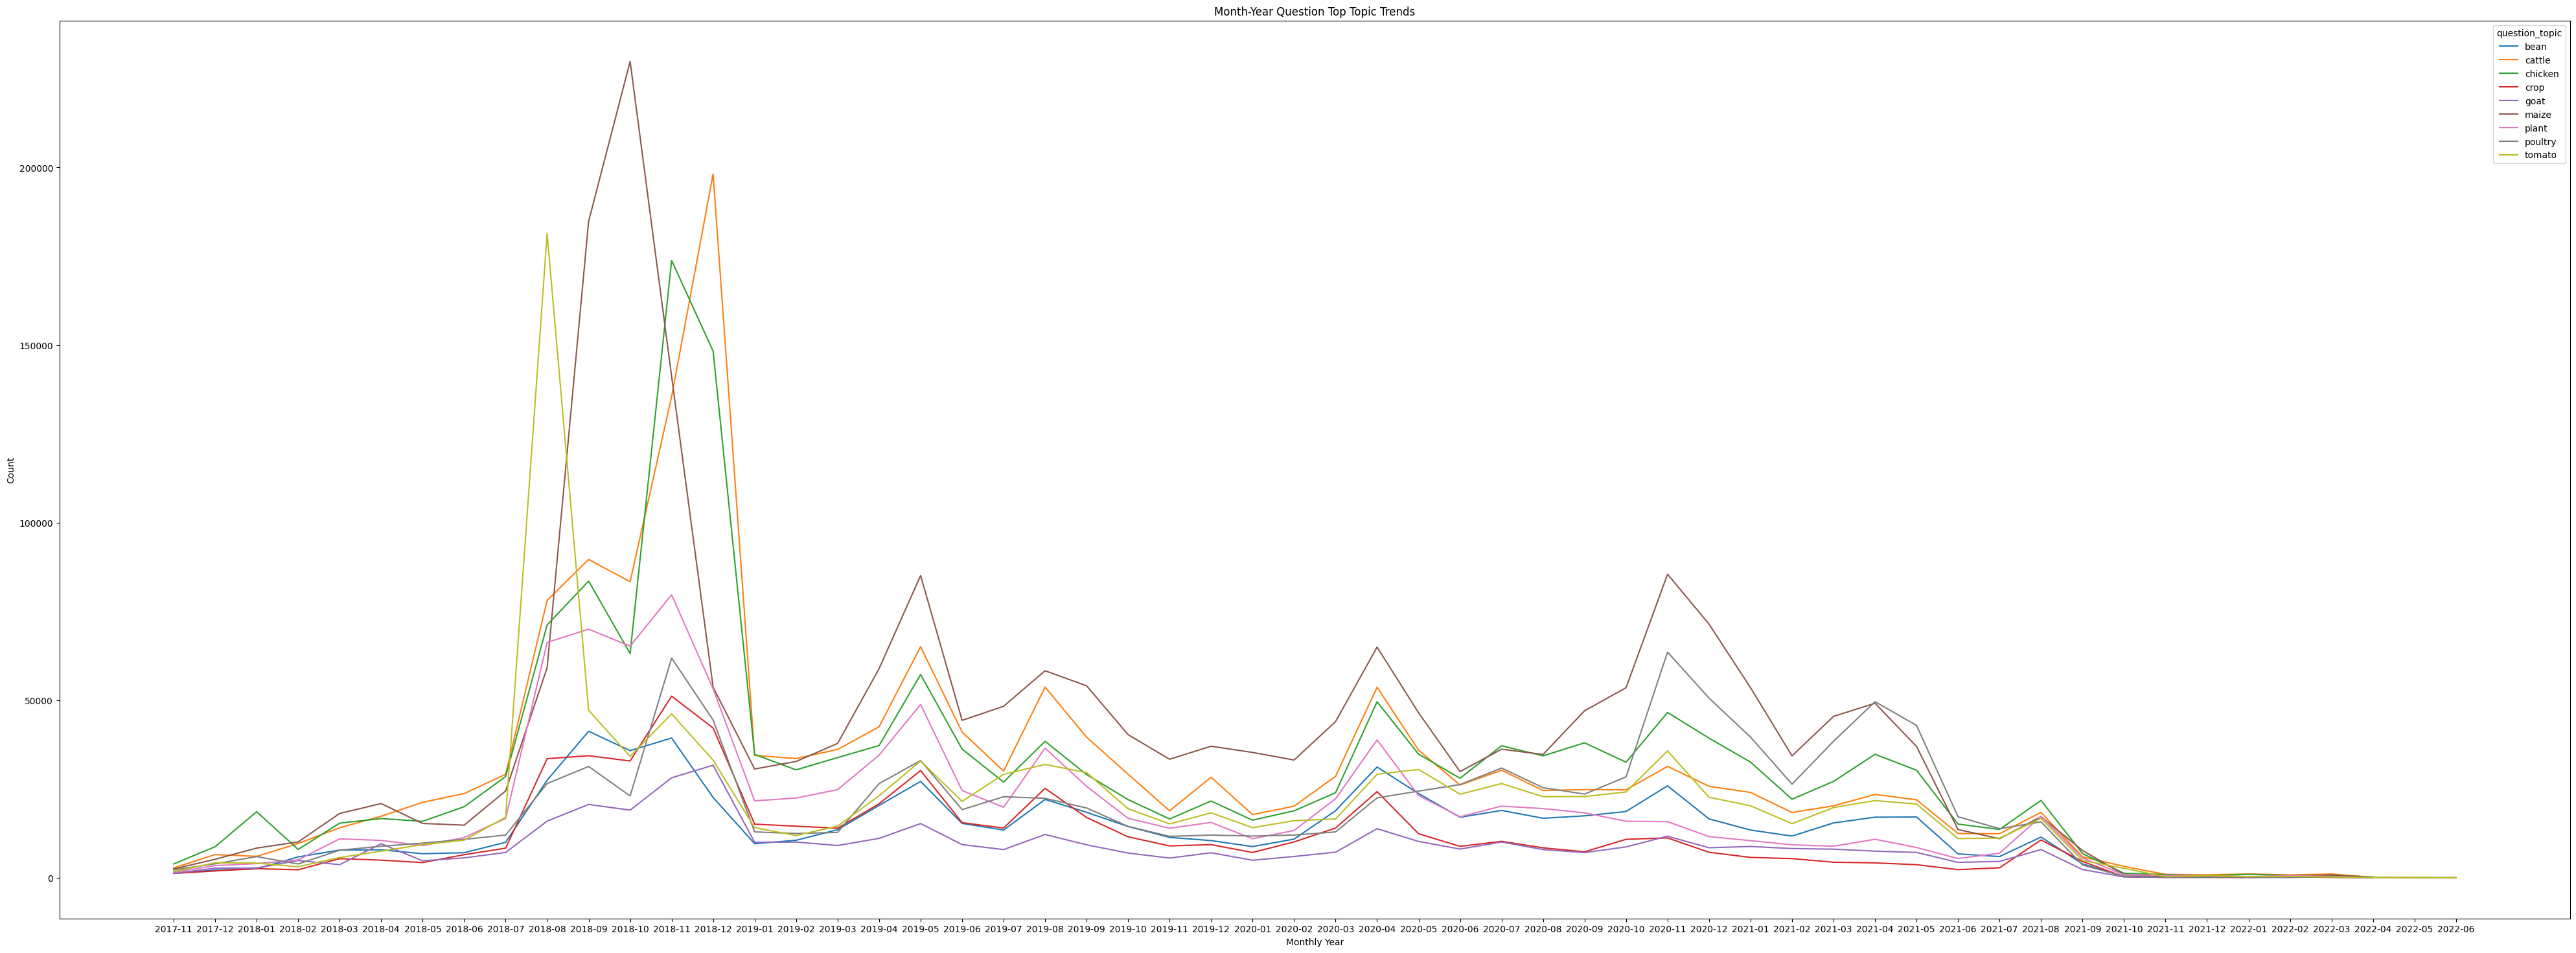

In [8]:
# Visualizing line plot of Month and Year top topic trends from 2017-2022 

query_monthly_top_topics = f"""
    SELECT
        strftime(question_sent, '%Y-%m') AS year_month,
        question_topic,
        COUNT(*) AS count
    FROM all_data
    WHERE question_topic IN ({','.join([f"'{topic}'" for topic in top_ten_topics_list])})
    GROUP BY
        year_month,
        question_topic
    ORDER BY
        year_month,
        question_topic;
"""

monthly_top_topics = conn.execute(query_monthly_top_topics).fetchdf()

plt.figure(figsize=(50, 18))
sns.lineplot(data=monthly_top_topics, x='year_month', y='count', hue='question_topic')
plt.xlabel('Monthly Year')
plt.ylabel('Count')
plt.title('Month-Year Question Top Topic Trends')
plt.show()

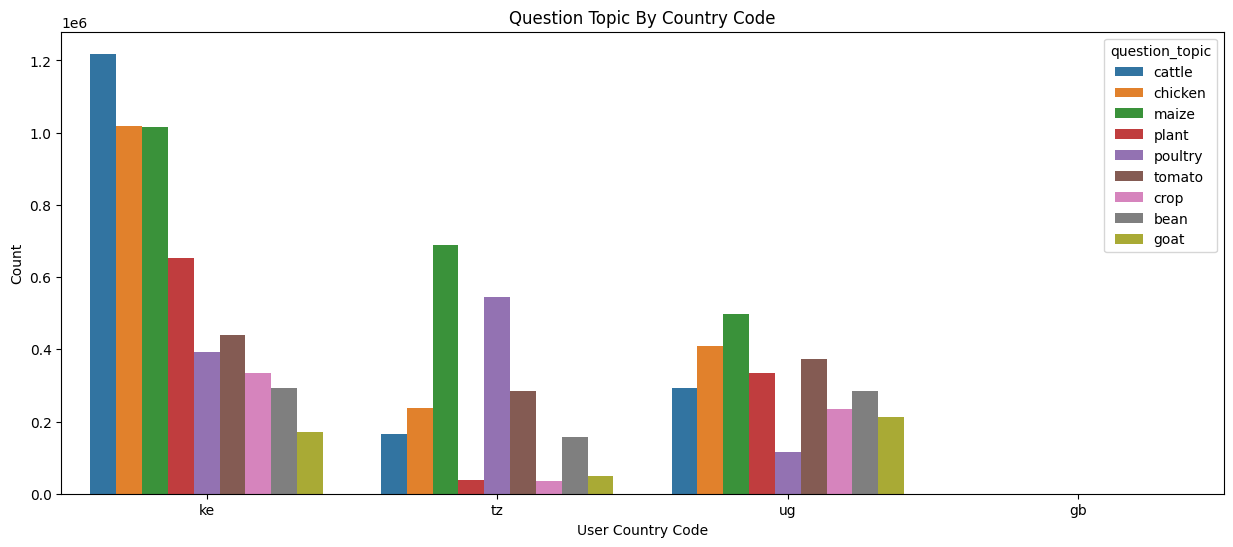

In [9]:
# Visualizing bar plot of question topics by country code

query_country_topic = f"""
    SELECT 
        question_topic,
        question_user_country_code,
        COUNT(*) AS count
    FROM all_data
    WHERE question_topic IN ({','.join([f"'{topic}'" for topic in top_ten_topics_list])})
    GROUP BY 
        question_topic,
        question_user_country_code
    ORDER BY 
        count DESC
"""

country_topic = conn.execute(query_country_topic).fetchdf()

plt.figure(figsize=(15, 6))
sns.barplot(data=country_topic, x='question_user_country_code', y='count', hue='question_topic')
plt.xlabel('User Country Code')
plt.ylabel('Count')
plt.title('Question Topic By Country Code')
plt.show()
conn.close()

## Inspecting Global Historical Climatology Network daily and Climate Change Knowledge Portal Data Sets 

In [10]:
# File path to the GHCND filtered parquet file and ERA5 data sets
ghcnd_processed_path = current_directory.joinpath('../../data/ghcnd_all_parsed.parquet')

kenya_era5_path = current_directory.joinpath('../../data/era5_kenya.xlsx')
tanzania_era5_path =  current_directory.joinpath('../../data/era5_tanzania.xlsx')
uganda_era5_path = current_directory.joinpath('../../data/era5_uganda.xlsx')

In [11]:
# Looking at GHCND filtered parquet file and splitting country data
ghcnd_parquet_filtered_df = pd.read_parquet(ghcnd_processed_path)

ghcnd_parquet_filtered_df['DATE'] = pd.to_datetime(ghcnd_parquet_filtered_df['DATE'])

kenya_ghcnd_df = ghcnd_parquet_filtered_df[ghcnd_parquet_filtered_df['STATION'].str.startswith('KE')]
tanzania_ghcnd_df = ghcnd_parquet_filtered_df[ghcnd_parquet_filtered_df['STATION'].str.startswith('TZ')]

In [12]:
def transform_filter_elements_years(df, element, start_year, end_year):
    # A function to obtain specified element from start year - end year and transforms VALUES to a tenth of VALUES - applies to TEMP and PRCP values 
    df = df.copy()
    
    df = df[(df['ELEMENT'] == element) & (df['DATE'].dt.year >= start_year) & (df['DATE'].dt.year <= end_year)].copy()

    df['SCALED VALUE'] = df['VALUE'].astype(float)
    df['SCALED VALUE'] = df['SCALED VALUE'] / 10
        
    return df

### Kenya's Historical and Recent Yearly Weather Data for Each Station

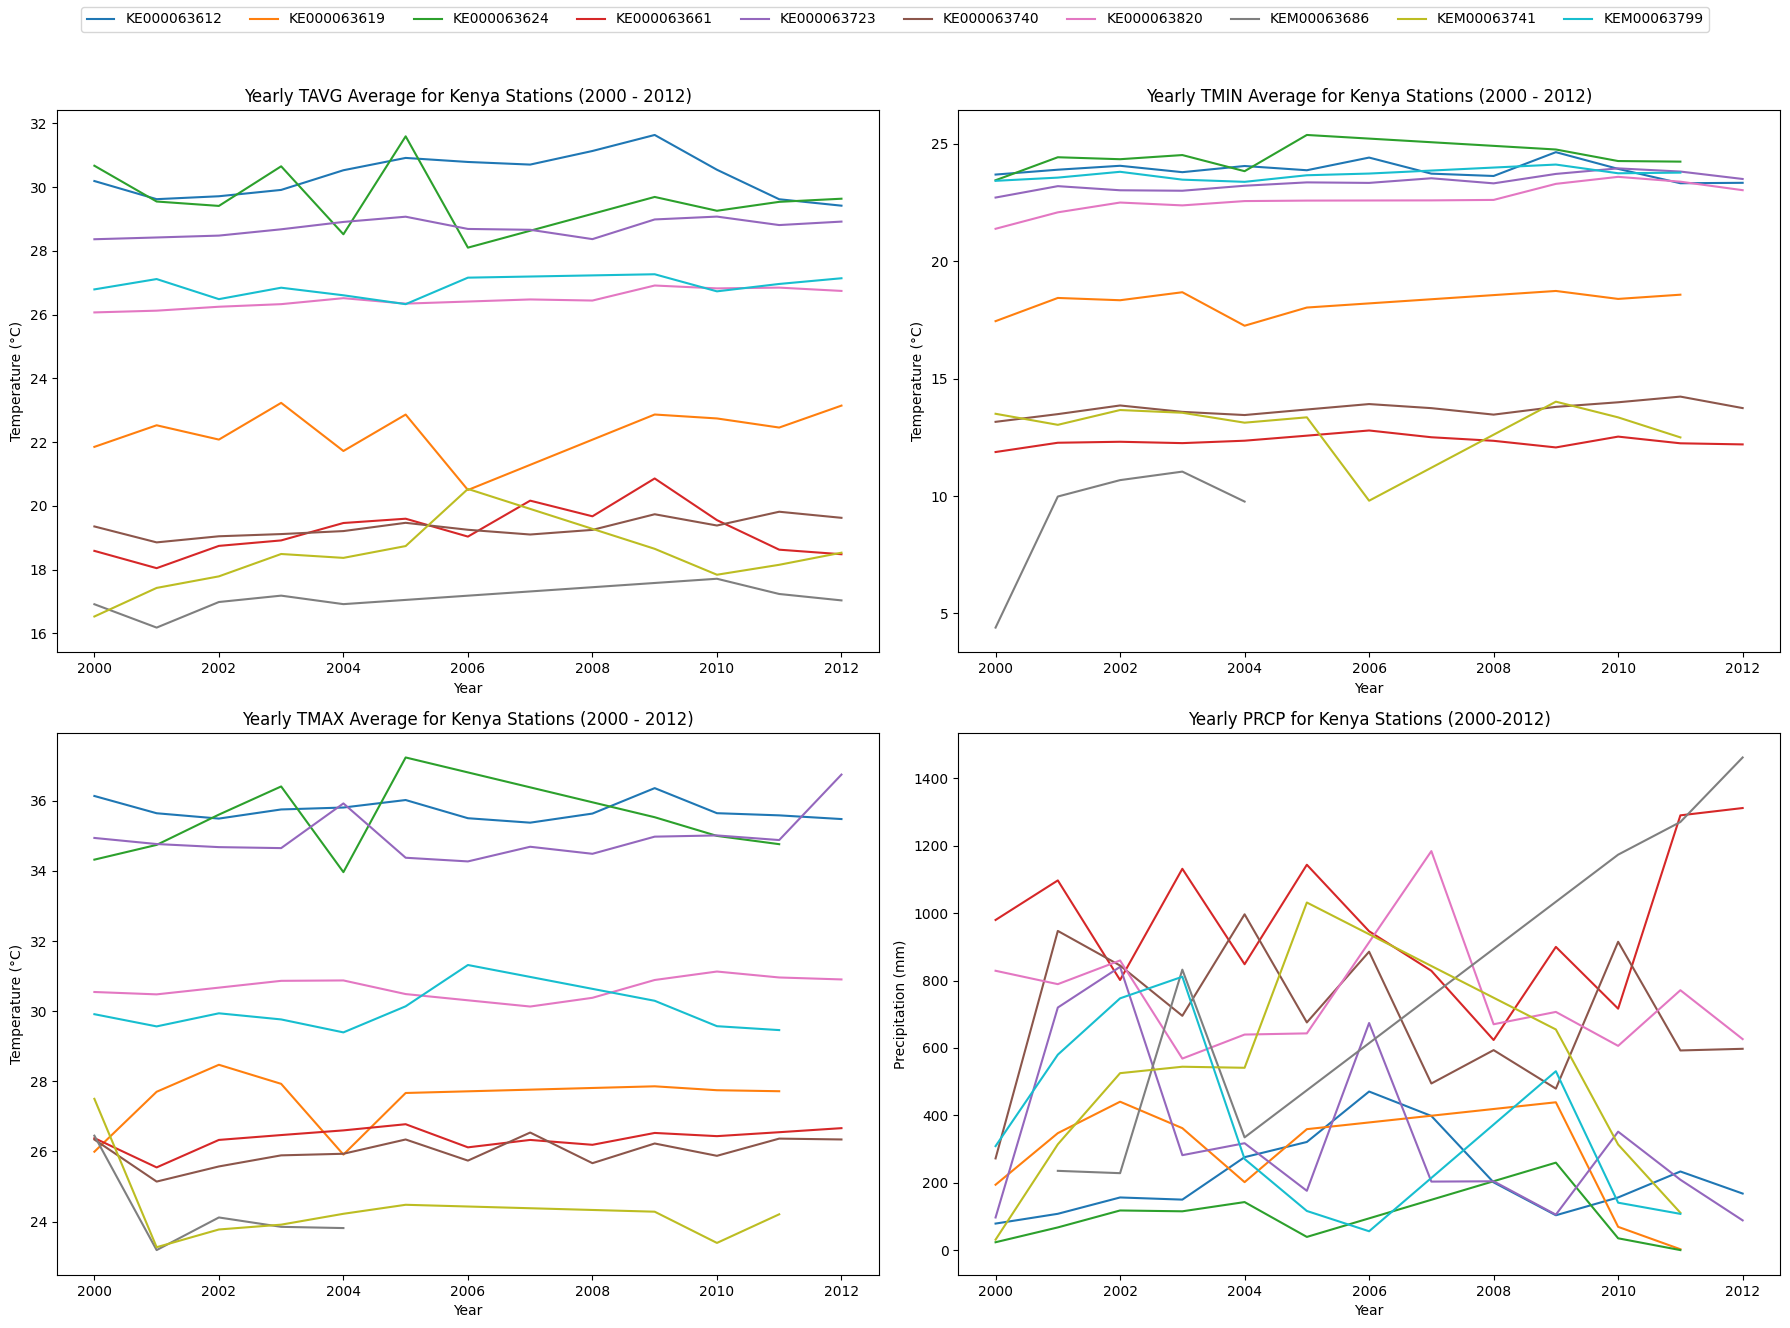

In [13]:
# Filtering Kenya's stations for elements TAVG, TMIN, TMAX AND PRCP from 2000 - 2022
kenya_df_TAVG = transform_filter_elements_years(kenya_ghcnd_df, 'TAVG', 2000, 2022)
kenya_df_TMIN = transform_filter_elements_years(kenya_ghcnd_df, 'TMIN', 2000, 2022)
kenya_df_TMAX = transform_filter_elements_years(kenya_ghcnd_df, 'TMAX', 2000, 2022)
kenya_df_PRCP = transform_filter_elements_years(kenya_ghcnd_df, 'PRCP', 2000, 2022)

# first decade from 2000 - 2012
kenya_first_dec_TAVG = kenya_df_TAVG[kenya_df_TAVG['DATE'].dt.year <= 2012]
kenya_first_dec_TMIN = kenya_df_TMIN[kenya_df_TMIN['DATE'].dt.year <= 2012]
kenya_first_dec_TMAX = kenya_df_TMAX[kenya_df_TMAX['DATE'].dt.year <= 2012]
kenya_first_dec_PRCP = kenya_df_PRCP[kenya_df_PRCP['DATE'].dt.year <= 2012]

# Graphing First Decades Yearly Trends
kenya_fTAVG_group = kenya_first_dec_TAVG.groupby([kenya_first_dec_TAVG['STATION'], kenya_first_dec_TAVG['DATE'].dt.year])['SCALED VALUE'].mean().to_frame()
kenya_fTMIN_group = kenya_first_dec_TMIN.groupby([kenya_first_dec_TMIN['STATION'], kenya_first_dec_TMIN['DATE'].dt.year])['SCALED VALUE'].mean().to_frame()
kenya_fTMAX_group = kenya_first_dec_TMAX.groupby([kenya_first_dec_TMAX['STATION'], kenya_first_dec_TMAX['DATE'].dt.year])['SCALED VALUE'].mean().to_frame()
kenya_fPRCP_group = kenya_first_dec_PRCP.groupby([kenya_first_dec_PRCP['STATION'], kenya_first_dec_PRCP['DATE'].dt.year])['SCALED VALUE'].sum().to_frame()

df_list = [kenya_fTAVG_group, kenya_fTMIN_group, kenya_fTMAX_group, kenya_fPRCP_group]
plot_titles = ['Yearly TAVG Average for Kenya Stations (2000 - 2012)', 'Yearly TMIN Average for Kenya Stations (2000 - 2012)', 'Yearly TMAX Average for Kenya Stations (2000 - 2012)',
              'Yearly PRCP for Kenya Stations (2000-2012)']
y_labels = ['Temperature (°C)', 'Temperature (°C)', 'Temperature (°C)', 'Precipitation (mm)']

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(18, 14))

axes = axes.flatten()

for i, df in enumerate(df_list): 
    df = df.reset_index()

    legend_on = True if i == 0 else False
    
    sns.lineplot(
        data=df,
        x='DATE',
        y= 'SCALED VALUE',
        hue = 'STATION',
        ax=axes[i],
        legend = legend_on
    )
    
    axes[i].set_title(plot_titles[i])
    axes[i].set_xlabel('Year')
    axes[i].set_ylabel(y_labels[i])

handles, labels =  axes[0].get_legend_handles_labels()
axes[0].legend().remove()

fig.legend(handles, labels, loc='upper center', ncol=len(labels))

plt.tight_layout(rect=[0, 0.05, 1, 0.95])
plt.show()

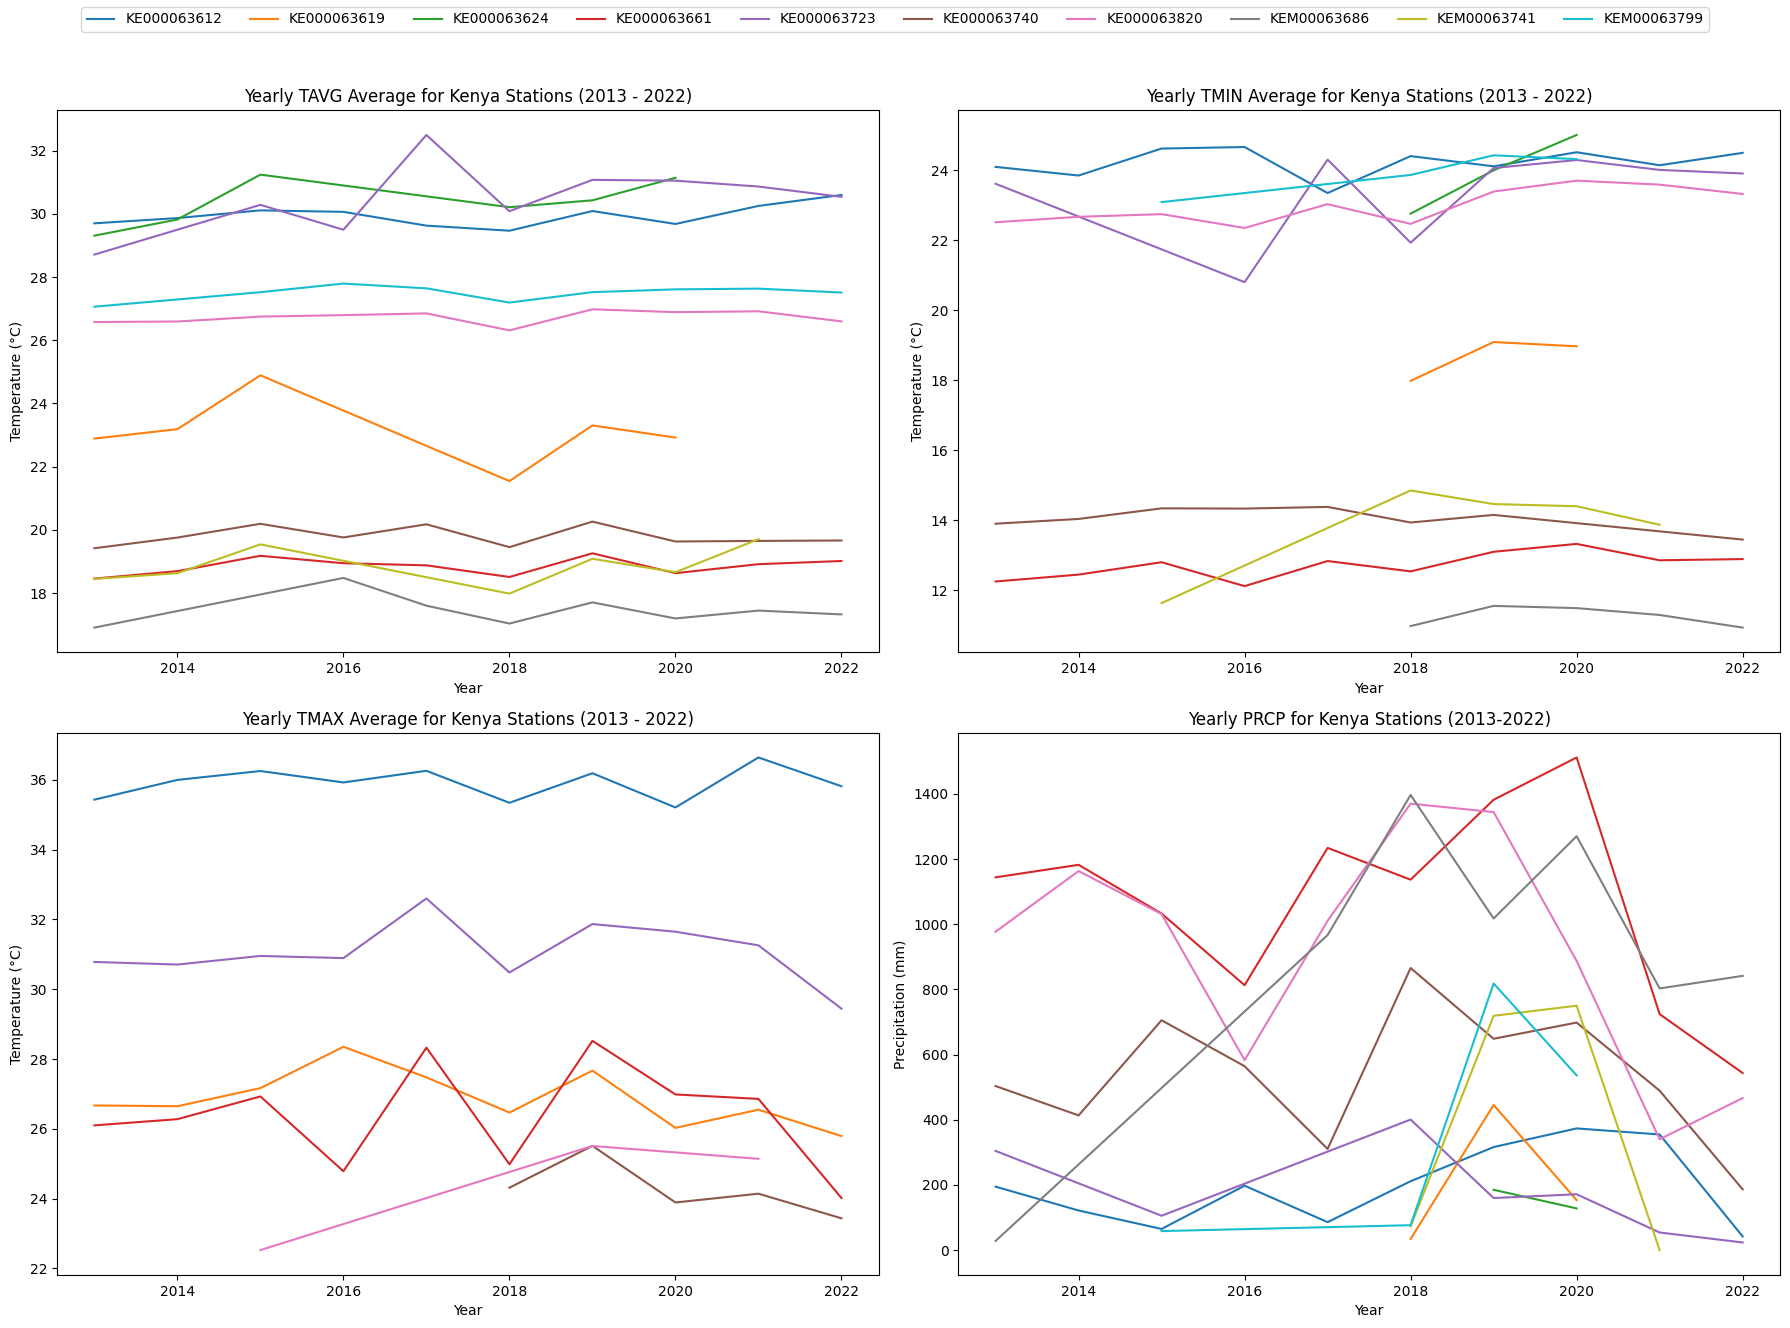

In [14]:
# second decade from 2013 - 2022
kenya_second_dec_TAVG = kenya_df_TAVG[kenya_df_TAVG['DATE'].dt.year > 2012]
kenya_second_dec_TMIN = kenya_df_TMIN[kenya_df_TMIN['DATE'].dt.year > 2012]
kenya_second_dec_TMAX = kenya_df_TMAX[kenya_df_TMAX['DATE'].dt.year > 2012]
kenya_second_dec_PRCP = kenya_df_PRCP[kenya_df_PRCP['DATE'].dt.year > 2012]

# Graphing Second Decades Yearly Trends
kenya_TAVG_sec_group = kenya_second_dec_TAVG.groupby([kenya_second_dec_TAVG['STATION'], kenya_second_dec_TAVG['DATE'].dt.year])['SCALED VALUE'].mean().to_frame()
kenya_TMIN_sec_group = kenya_second_dec_TMIN.groupby([kenya_second_dec_TMIN['STATION'], kenya_second_dec_TMIN['DATE'].dt.year])['SCALED VALUE'].mean().to_frame()
kenya_TMAX_sec_group = kenya_second_dec_TMAX.groupby([kenya_second_dec_TMAX['STATION'], kenya_second_dec_TMAX['DATE'].dt.year])['SCALED VALUE'].mean().to_frame()
kenya_PRCP_sec_group = kenya_second_dec_PRCP.groupby([kenya_second_dec_PRCP['STATION'], kenya_second_dec_PRCP['DATE'].dt.year])['SCALED VALUE'].sum().to_frame()

df_second_list = [kenya_TAVG_sec_group, kenya_TMIN_sec_group, kenya_TMAX_sec_group, kenya_PRCP_sec_group]
sec_plot_titles = ['Yearly TAVG Average for Kenya Stations (2013 - 2022)', 'Yearly TMIN Average for Kenya Stations (2013 - 2022)', 'Yearly TMAX Average for Kenya Stations (2013 - 2022)',
              'Yearly PRCP for Kenya Stations (2013-2022)']
sec_y_labels = ['Temperature (°C)', 'Temperature (°C)', 'Temperature (°C)', 'Precipitation (mm)']

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(18, 14))

axes = axes.flatten()

for i, df in enumerate(df_second_list): 
    df = df.reset_index()

    legend_on = True if i == 0 else False
    
    sns.lineplot(
        data=df,
        x='DATE',
        y= 'SCALED VALUE',
        hue = 'STATION',
        ax=axes[i],
        legend = legend_on
    )
    
    axes[i].set_title(sec_plot_titles[i])
    axes[i].set_xlabel('Year')
    axes[i].set_ylabel(sec_y_labels[i])

handles, labels =  axes[0].get_legend_handles_labels()
axes[0].legend().remove()

fig.legend(handles, labels, loc='upper center', ncol=len(labels))

plt.tight_layout(rect=[0, 0.05, 1, 0.95])
plt.show()

### Kenya's ERA5 Data and Comparing with GHCND Data at Country Level

In [15]:
# Combining prcp, tasmax, and tasmin into one data frame
kenya_era5_prcp_df = pd.read_excel(kenya_era5_path, sheet_name=0)
kenya_era5_prcp_df = pd.melt(kenya_era5_prcp_df, id_vars=['code', 'name'], var_name='date', value_name='prcp value')

kenya_era5_tasmax_df = pd.read_excel(kenya_era5_path, sheet_name=1)
kenya_era5_tasmax_df = pd.melt(kenya_era5_tasmax_df, id_vars=['code', 'name'], var_name='date', value_name='tasmax value')

kenya_era5_tasmin_df = pd.read_excel(kenya_era5_path, sheet_name=2)
kenya_era5_tasmin_df = pd.melt(kenya_era5_tasmin_df, id_vars=['code', 'name'], var_name='date', value_name='tasmin value')

kenya_era5_df = pd.merge(kenya_era5_prcp_df, kenya_era5_tasmax_df, on=['code', 'name', 'date'])
kenya_era5_df = pd.merge(kenya_era5_df, kenya_era5_tasmin_df, on=['code', 'name', 'date'])

kenya_era5_df['date'] = pd.to_datetime(kenya_era5_df['date'])
kenya_era5_df.describe()

,date,prcp value,tasmax value,tasmin value
count,876,876.00000,876.000000,876.000000
mean,1986-06-16 13:58:21.369863040,63.96984,30.023174,20.288836
min,1950-01-01 00:00:00,2.46000,26.180000,17.940000
25%,1968-03-24 06:00:00,35.89500,28.857500,19.597500
50%,1986-06-16 00:00:00,50.89500,29.905000,20.265000
75%,2004-09-08 12:00:00,81.88000,31.022500,20.962500
max,2022-12-01 00:00:00,280.32000,34.390000,23.530000
std,NaN,42.71524,1.540268,0.991181


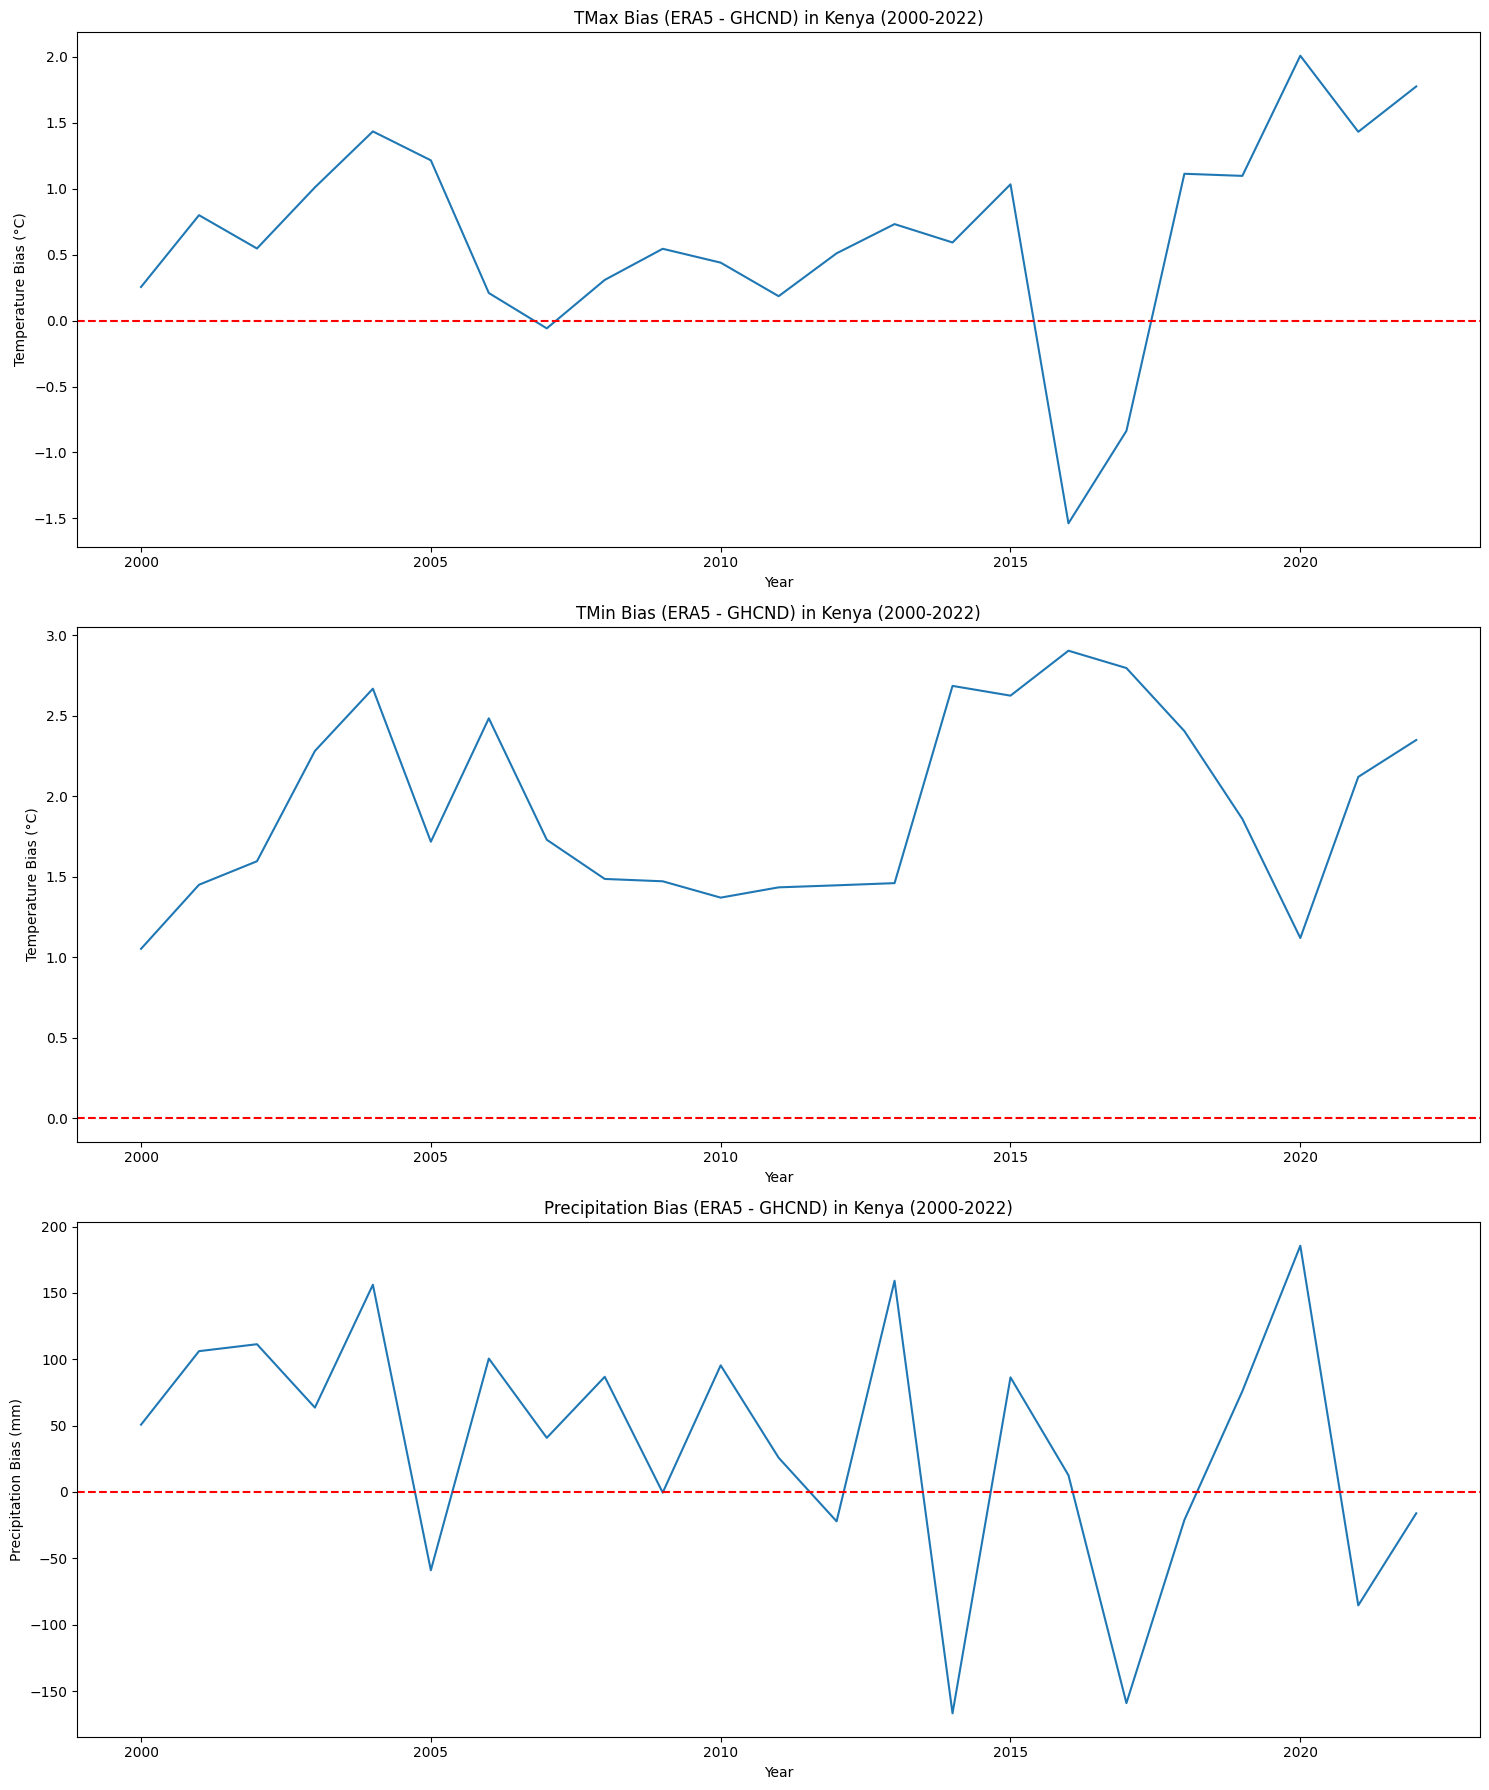

In [16]:
# Looking at ERA5's Model Bias in comparison to GHCND Data 
# Model Bias = ERA5 DATA (#SPECIFIED ELEMENT) - GHCND DATA (#SPECIFIED ELEMENT)

kenya_era5 = kenya_era5_df[(kenya_era5_df['date'].dt.year >= 2000) & (kenya_era5_df['date'].dt.year <= 2022)]

kenya_era5_yearly = kenya_era5.groupby(kenya_era5['date'].dt.year).agg(
    tasmax=('tasmax value', 'mean'),
    tasmin=('tasmin value', 'mean'),
    prcp=('prcp value', 'sum')
).reset_index()

# scaling up GHCND daily level to country level
kenya_TAVG_monthly_station = kenya_df_TAVG.groupby([kenya_df_TAVG['STATION'], kenya_df_TAVG['DATE'].dt.to_period('M')])['SCALED VALUE'].mean().reset_index()
kenya_TMIN_monthly_station = kenya_df_TMIN.groupby([kenya_df_TMIN['STATION'],  kenya_df_TMIN['DATE'].dt.to_period('M')])['SCALED VALUE'].mean().reset_index()
kenya_TMAX_monthly_station = kenya_df_TMAX.groupby([kenya_df_TMAX['STATION'],  kenya_df_TMAX['DATE'].dt.to_period('M')])['SCALED VALUE'].mean().reset_index()
kenya_PRCP_monthly_station = kenya_df_PRCP.groupby([kenya_df_PRCP['STATION'], kenya_df_PRCP['DATE'].dt.to_period('M')])['SCALED VALUE'].sum().reset_index()

kenya_TAVG_monthly_station['ELEMENT'] = 'TAVG'
kenya_TMIN_monthly_station['ELEMENT'] = 'TMIN'
kenya_TMAX_monthly_station['ELEMENT'] = 'TMAX'
kenya_PRCP_monthly_station['ELEMENT'] = 'PRCP'

kenya_ghcnd_combine = pd.concat([kenya_TAVG_monthly_station, kenya_TMIN_monthly_station, kenya_TMAX_monthly_station, kenya_PRCP_monthly_station]).reset_index()

kenya_monthly_avg_region = kenya_ghcnd_combine.groupby(['DATE', 'ELEMENT'])['SCALED VALUE'].mean().reset_index()

kenya_monthly_avg_pivot = pd.pivot_table(kenya_monthly_avg_region, 
                                         values='SCALED VALUE', 
                                         index='DATE',
                                         columns='ELEMENT').reset_index()

kenya_yearly_avg = kenya_monthly_avg_pivot.groupby(kenya_monthly_avg_pivot['DATE'].dt.year).agg(
    avg_tavg=('TAVG', 'mean'),
    avg_tmin=('TMIN', 'mean'),
    avg_tmax=('TMAX', 'mean'),
    sum_prcp=('PRCP', 'sum')
).reset_index()

# comparison dataframes
comparison_tmax = pd.merge(kenya_era5_yearly, kenya_yearly_avg, left_on='date', right_on='DATE')
comparison_tmax['TMax Bias'] = comparison_tmax['tasmax'] - comparison_tmax['avg_tmax']

comparison_tmin = pd.merge(kenya_era5_yearly, kenya_yearly_avg, left_on='date', right_on='DATE')
comparison_tmin['TMin Bias'] = comparison_tmin['tasmin'] - comparison_tmin['avg_tmin']

comparison_prcp = pd.merge(kenya_era5_yearly, kenya_yearly_avg, left_on='date', right_on='DATE')
comparison_prcp['PRCP Bias'] = comparison_prcp['prcp'] - comparison_prcp['sum_prcp']

# graphing model bias for each element and all years
comparison_list = [
    {'df': comparison_tmax, 'bias_col': 'TMax Bias', 'title': 'TMax Bias (ERA5 - GHCND) in Kenya (2000-2022)', 'ylabel': 'Temperature Bias (°C)'},
    {'df': comparison_tmin, 'bias_col': 'TMin Bias', 'title': 'TMin Bias (ERA5 - GHCND) in Kenya (2000-2022)', 'ylabel': 'Temperature Bias (°C)'},
    {'df': comparison_prcp, 'bias_col': 'PRCP Bias', 'title': 'Precipitation Bias (ERA5 - GHCND) in Kenya (2000-2022)', 'ylabel': 'Precipitation Bias (mm)'}
]

fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(15, 18))
axes = axes.flatten()

for i, plot_config in enumerate(comparison_list):
    sns.lineplot(data=plot_config['df'], x='date', y=plot_config['bias_col'], ax=axes[i])
    
    axes[i].set_title(plot_config['title'])
    axes[i].set_xlabel('Year')
    axes[i].set_ylabel(plot_config['ylabel'])
    axes[i].axhline(0, color='red', linestyle='--') 

plt.tight_layout()
plt.show()

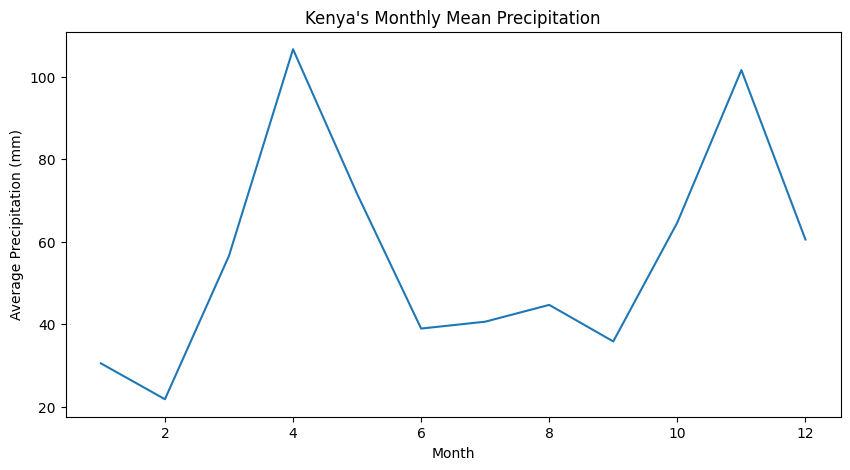

In [17]:
# Keeping Precipitation Bias in mind when looking at Kenya's Monthly Precipitation Trends.
monthly_precip_plot = kenya_era5.copy()

monthly_precip_plot = monthly_precip_plot.groupby(monthly_precip_plot['date'].dt.month).agg(
    monthly_prcp=('prcp value', 'mean')
)

plt.figure(figsize=(10, 5))
sns.lineplot(data=monthly_precip_plot, x='date', y='monthly_prcp')
plt.xlabel('Month')
plt.ylabel('Average Precipitation (mm)')
plt.title('Kenya\'s Monthly Mean Precipitation')
plt.show()

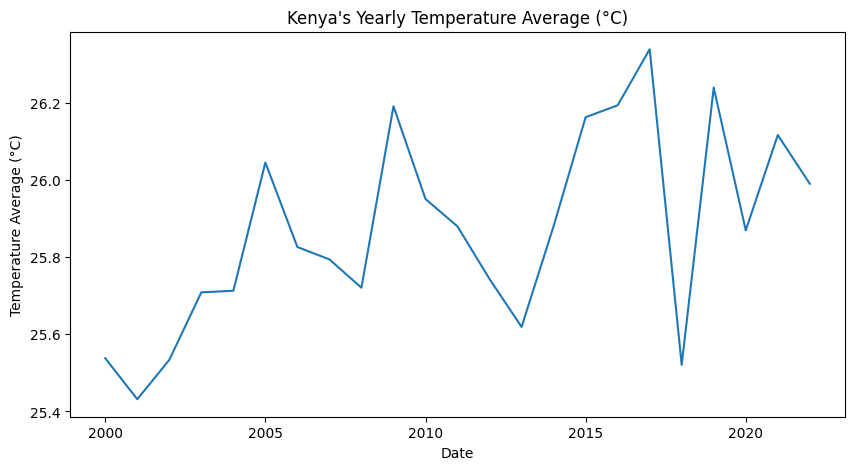

In [18]:
# Kenya's Yearly TAVG Trends via ERA5 data
tavg_era5 = kenya_era5.copy()
tavg_era5['tavg'] = (tavg_era5['tasmax value'] + tavg_era5['tasmin value']) / 2

yearly_tavg_plot = tavg_era5.groupby(tavg_era5['date'].dt.year).agg(
    avg_tavg = ('tavg', 'mean')
).reset_index()

plt.figure(figsize=(10, 5))
sns.lineplot(data=yearly_tavg_plot, x='date', y='avg_tavg')
plt.xlabel('Date')
plt.ylabel('Temperature Average (°C)')
plt.title('Kenya\'s Yearly Temperature Average (°C)')
plt.show()

### Tanzania's GHCND and ERA5 Country Level Monthly and Yearly Trends 

In [19]:
tanz_era5_prcp_df = pd.read_excel(tanzania_era5_path, sheet_name=0)
tanz_era5_prcp_df = pd.melt(tanz_era5_prcp_df, id_vars=['code', 'name'], var_name='date', value_name='prcp value')

tanz_era5_tasmax_df = pd.read_excel(tanzania_era5_path, sheet_name=1)
tanz_era5_tasmax_df = pd.melt(tanz_era5_tasmax_df, id_vars=['code', 'name'], var_name='date', value_name='tasmax value')

tanz_era5_tasmin_df = pd.read_excel(tanzania_era5_path, sheet_name=2)
tanz_era5_tasmin_df = pd.melt(tanz_era5_tasmin_df, id_vars=['code', 'name'], var_name='date', value_name='tasmin value')

tanzania_era5_df = pd.merge(tanz_era5_prcp_df, tanz_era5_tasmax_df, on=['code', 'name', 'date'])
tanzania_era5_df = pd.merge(tanzania_era5_df, tanz_era5_tasmin_df, on=['code', 'name', 'date'])

tanzania_era5_df['date'] = pd.to_datetime(tanzania_era5_df['date'])
tanzania_era5_df.describe() 

,date,prcp value,tasmax value,tasmin value
count,876,876.000000,876.000000,876.000000
mean,1986-06-16 13:58:21.369863040,97.288904,27.510183,17.958379
min,1950-01-01 00:00:00,3.050000,24.540000,14.120000
25%,1968-03-24 06:00:00,18.115000,26.560000,16.847500
50%,1986-06-16 00:00:00,76.665000,27.360000,18.280000
75%,2004-09-08 12:00:00,166.705000,28.470000,18.990000
max,2022-12-01 00:00:00,357.790000,30.980000,20.820000
std,NaN,81.933593,1.273020,1.379222


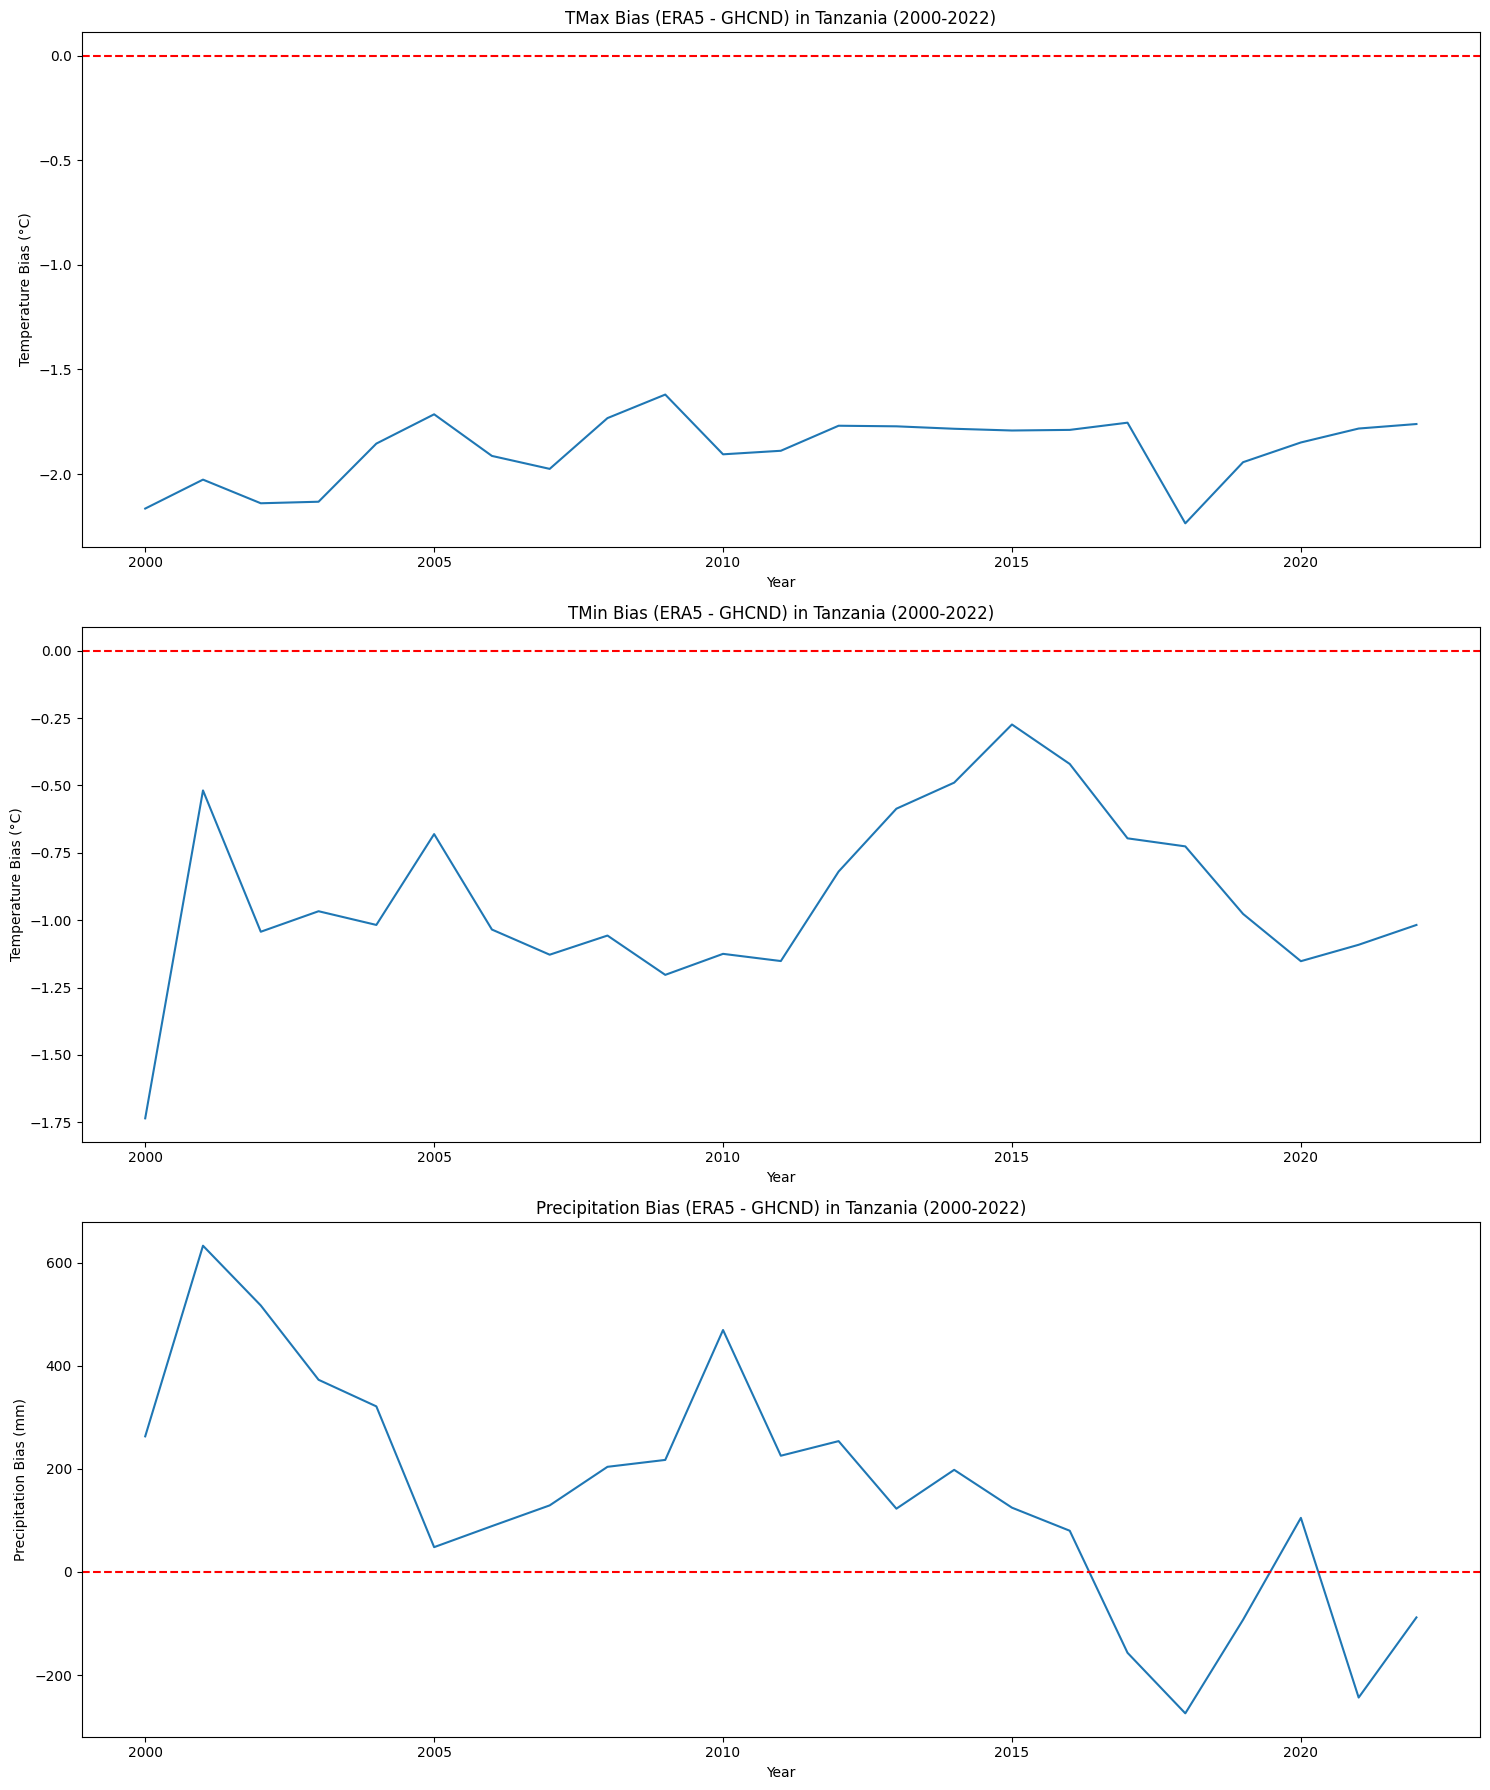

In [20]:
# Model Bias between GHCND and ERA5 data for Tanzania

# Scaling up to Country Level for ERA5 Data
tanzania_era5 = tanzania_era5_df[(tanzania_era5_df['date'].dt.year >= 2000) & (tanzania_era5_df['date'].dt.year <= 2022)]

tanzania_era5_yearly = tanzania_era5.groupby(tanzania_era5['date'].dt.year).agg(
    tasmax=('tasmax value', 'mean'),
    tasmin=('tasmin value', 'mean'),
    prcp=('prcp value', 'sum')
).reset_index()

# Scaling up to Country Level for GHCND Data
tanzania_df_TMIN = transform_filter_elements_years(tanzania_ghcnd_df, 'TMIN', 2000, 2022)
tanzania_df_TMAX = transform_filter_elements_years(tanzania_ghcnd_df, 'TMAX', 2000, 2022)
tanzania_df_PRCP = transform_filter_elements_years(tanzania_ghcnd_df, 'PRCP', 2000, 2022)
 
tanzania_TMIN_monthly_station = tanzania_df_TMIN.groupby([tanzania_df_TMIN['STATION'], tanzania_df_TMIN['DATE'].dt.to_period('M')])['SCALED VALUE'].mean().reset_index()
tanzania_TMAX_monthly_station = tanzania_df_TMAX.groupby([tanzania_df_TMAX['STATION'], tanzania_df_TMAX['DATE'].dt.to_period('M')])['SCALED VALUE'].mean().reset_index()
tanzania_PRCP_monthly_station = tanzania_df_PRCP.groupby([tanzania_df_PRCP['STATION'], tanzania_df_PRCP['DATE'].dt.to_period('M')])['SCALED VALUE'].sum().reset_index()

tanzania_TMIN_monthly_station['ELEMENT'] = 'TMIN'
tanzania_TMAX_monthly_station['ELEMENT'] = 'TMAX'
tanzania_PRCP_monthly_station['ELEMENT'] = 'PRCP'

tanzania_ghcnd_combine = pd.concat([tanzania_TMIN_monthly_station, tanzania_TMAX_monthly_station, tanzania_PRCP_monthly_station]).reset_index()

tanzania_monthly_avg_region = tanzania_ghcnd_combine.groupby(['DATE', 'ELEMENT'])['SCALED VALUE'].mean().reset_index()

tanzania_monthly_avg_pivot = pd.pivot_table(tanzania_monthly_avg_region, 
                                         values='SCALED VALUE', 
                                         index='DATE',
                                         columns='ELEMENT').reset_index()

tanzania_yearly_avg = tanzania_monthly_avg_pivot.groupby(tanzania_monthly_avg_pivot['DATE'].dt.year).agg(
    avg_tmin=('TMIN', 'mean'),
    avg_tmax=('TMAX', 'mean'),
    sum_prcp=('PRCP', 'sum')
).reset_index()

# comparison dataframes
comparison_tmax_tanz = pd.merge(tanzania_era5_yearly, tanzania_yearly_avg, left_on='date', right_on='DATE')
comparison_tmax_tanz['TMax Bias'] = comparison_tmax_tanz['tasmax'] - comparison_tmax_tanz['avg_tmax']

comparison_tmin_tanz = pd.merge(tanzania_era5_yearly, tanzania_yearly_avg, left_on='date', right_on='DATE')
comparison_tmin_tanz['TMin Bias'] = comparison_tmin_tanz['tasmin'] - comparison_tmin_tanz['avg_tmin']

comparison_prcp_tanz = pd.merge(tanzania_era5_yearly, tanzania_yearly_avg, left_on='date', right_on='DATE')
comparison_prcp_tanz['PRCP Bias'] = comparison_prcp_tanz['prcp'] - comparison_prcp_tanz['sum_prcp']

# graphing model bias for each element and all years
comparison_list_tanz = [
    {'df': comparison_tmax_tanz, 'bias_col': 'TMax Bias', 'title': 'TMax Bias (ERA5 - GHCND) in Tanzania (2000-2022)', 'ylabel': 'Temperature Bias (°C)'},
    {'df': comparison_tmin_tanz, 'bias_col': 'TMin Bias', 'title': 'TMin Bias (ERA5 - GHCND) in Tanzania (2000-2022)', 'ylabel': 'Temperature Bias (°C)'},
    {'df': comparison_prcp_tanz, 'bias_col': 'PRCP Bias', 'title': 'Precipitation Bias (ERA5 - GHCND) in Tanzania (2000-2022)', 'ylabel': 'Precipitation Bias (mm)'}
]

fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(15, 18))
axes = axes.flatten()

for i, plot_config in enumerate(comparison_list_tanz):
    sns.lineplot(data=plot_config['df'], x='date', y=plot_config['bias_col'], ax=axes[i])
    
    axes[i].set_title(plot_config['title'])
    axes[i].set_xlabel('Year')
    axes[i].set_ylabel(plot_config['ylabel'])
    axes[i].axhline(0, color='red', linestyle='--') 

plt.tight_layout()

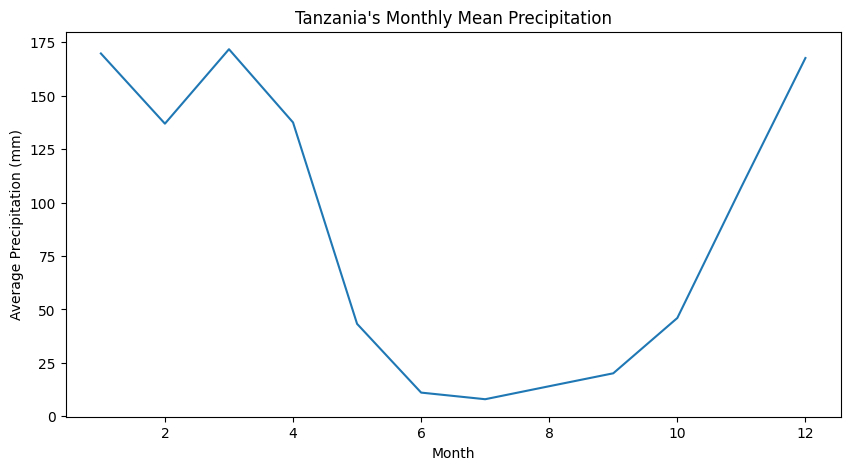

In [21]:
# Monthly Mean Rainfalls in Tanzania taking into consideration Precipitation Bias
monthly_precip_plot_tanz = tanzania_era5.copy()

monthly_precip_plot_tanz = monthly_precip_plot_tanz.groupby(monthly_precip_plot_tanz['date'].dt.month).agg(
    monthly_prcp=('prcp value', 'mean')
)

plt.figure(figsize=(10, 5))
sns.lineplot(data=monthly_precip_plot_tanz, x='date', y='monthly_prcp')
plt.xlabel('Month')
plt.ylabel('Average Precipitation (mm)')
plt.title('Tanzania\'s Monthly Mean Precipitation')
plt.show()

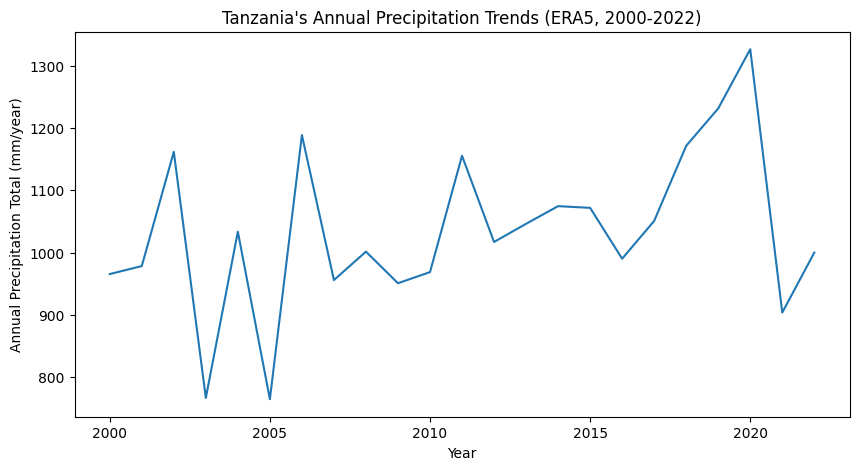

In [22]:
# Tanzania's Annual Precipitation 
plt.figure(figsize=(10, 5))
sns.lineplot(data=tanzania_era5_yearly, x='date', y='prcp')
plt.xlabel('Year')
plt.ylabel('Annual Precipitation Total (mm/year)')
plt.title('Tanzania\'s Annual Precipitation Trends (ERA5, 2000-2022)')
plt.show()

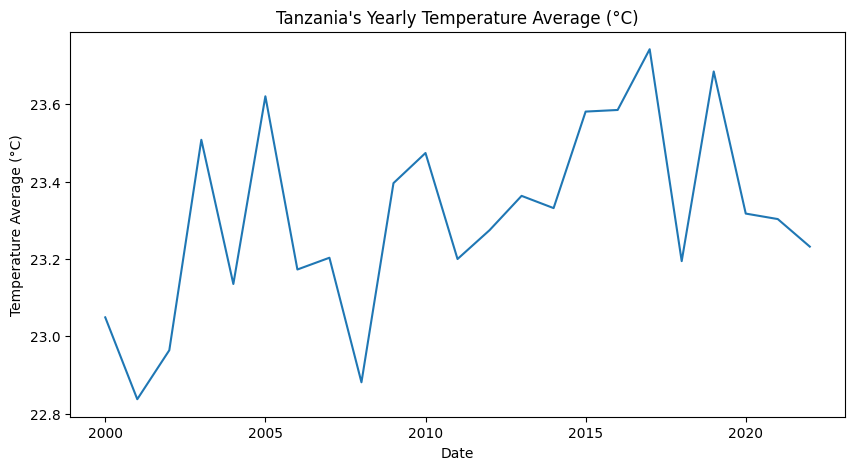

In [23]:
# Tanzania's Yearly TAVG Trends via ERA5 data
tavg_era5_tanz = tanzania_era5.copy()
tavg_era5_tanz['tavg'] = (tavg_era5_tanz['tasmax value'] + tavg_era5_tanz['tasmin value']) / 2

yearly_tavg_plot_tanz = tavg_era5_tanz.groupby(tavg_era5_tanz['date'].dt.year).agg(
    avg_tavg = ('tavg', 'mean')
).reset_index()

plt.figure(figsize=(10, 5))
sns.lineplot(data=yearly_tavg_plot_tanz, x='date', y='avg_tavg')
plt.xlabel('Date')
plt.ylabel('Temperature Average (°C)')
plt.title('Tanzania\'s Yearly Temperature Average (°C)')
plt.show()

### Uganda's ERA5 Data

In [62]:
# Unfortunately, GHCND data for Uganda only goes up to 1986, and so EDA on Uganda only uses the ERA5 data set.
ug_era5_prcp_df = pd.read_excel(uganda_era5_path, sheet_name=0)
ug_era5_prcp_df = pd.melt(ug_era5_prcp_df, id_vars=['code', 'name'], var_name='date', value_name='prcp value')

ug_era5_tasmax_df = pd.read_excel(uganda_era5_path, sheet_name=1)
ug_era5_tasmax_df = pd.melt(ug_era5_tasmax_df, id_vars=['code', 'name'], var_name='date', value_name='tasmax value')

ug_era5_tasmin_df = pd.read_excel(uganda_era5_path, sheet_name=2)
ug_era5_tasmin_df = pd.melt(ug_era5_tasmin_df, id_vars=['code', 'name'], var_name='date', value_name='tasmin value')

uganda_era5_df = pd.merge(ug_era5_prcp_df, ug_era5_tasmax_df, on=['code', 'name', 'date'])
uganda_era5_df = pd.merge(uganda_era5_df, ug_era5_tasmin_df, on=['code', 'name', 'date'])

uganda_era5_df['date'] = pd.to_datetime(uganda_era5_df['date'])
uganda_era5_df.describe() 

,date,prcp value,tasmax value,tasmin value
count,876,876.000000,876.000000,876.000000
mean,1986-06-16 13:58:21.369863040,148.794201,27.298744,18.510868
min,1950-01-01 00:00:00,12.160000,24.310000,16.690000
25%,1968-03-24 06:00:00,101.315000,26.290000,17.910000
50%,1986-06-16 00:00:00,147.645000,27.120000,18.460000
75%,2004-09-08 12:00:00,187.940000,28.075000,19.042500
max,2022-12-01 00:00:00,338.760000,31.990000,21.560000
std,NaN,61.247625,1.435962,0.831589


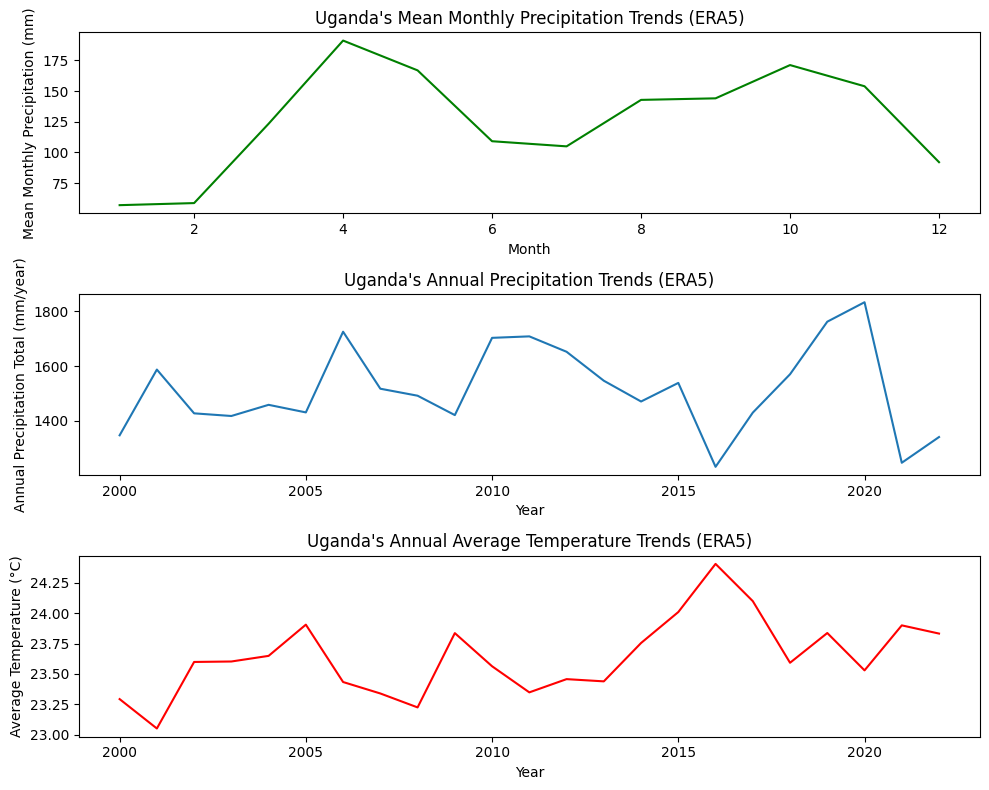

In [63]:
uganda_era5 = uganda_era5_df[(uganda_era5_df['date'].dt.year >= 2000) & (uganda_era5_df['date'].dt.year <= 2022)]

ug_era5 = uganda_era5.copy()
ug_era5['tavg value'] = (ug_era5['tasmax value'] + ug_era5['tasmin value']) / 2

uganda_era5_yearly = ug_era5.groupby(ug_era5['date'].dt.year).agg(
    tavg=('tavg value', 'mean'),
    tasmax=('tasmax value', 'mean'),
    tasmin=('tasmin value', 'mean'),
    prcp=('prcp value', 'sum')
).reset_index()

monthly_precip_plot_ug = uganda_era5.copy()

monthly_precip_plot_ug = monthly_precip_plot_ug.groupby(monthly_precip_plot_ug['date'].dt.month).agg(
    monthly_prcp=('prcp value', 'mean')
)


fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10, 8))
sns.lineplot(data=monthly_precip_plot_ug, x='date', y='monthly_prcp', ax=axes[0], color='green')
axes[0].set_title('Uganda\'s Mean Monthly Precipitation Trends (ERA5)')
axes[0].set_xlabel('Month')
axes[0].set_ylabel('Mean Monthly Precipitation (mm)')

sns.lineplot(data=uganda_era5_yearly, x='date', y='prcp', ax=axes[1])
axes[1].set_title('Uganda\'s Annual Precipitation Trends (ERA5)')
axes[1].set_xlabel('Year')
axes[1].set_ylabel('Annual Precipitation Total (mm/year)')

sns.lineplot(data=uganda_era5_yearly, x='date', y='tavg', ax=axes[2], color='red')
axes[2].set_title('Uganda\'s Annual Average Temperature Trends (ERA5)')
axes[2].set_xlabel('Year')
axes[2].set_ylabel('Average Temperature (°C)')

plt.tight_layout()
plt.show()